<div style="text-align: right"> &uarr;   Ensure Kernel is set to  &uarr;  </div><br><div style="text-align: right"> 
conda_python3  </div>

# PyTorch Estimator Bring your own Script

In this notebook we will go through and run a PyTorch model to classify the junctions as priority, signal and roundabout as seen in data prep.

The outline of this notebook is 

1. to prepare a training script (provided).

2. use the AWS provided PyTorch container and provide our script to it.

3. Run training.

4. deploy model to end point.

5. Test using an image in couple of possible ways 

Upgrade Sagemaker so we can access the latest containers

In [ ]:
!pip install -U sagemaker

Next we will import the libraries and set up the initial variables we will be using in this lab

In [ ]:
import os
import sagemaker
import numpy as np
from sagemaker.pytorch import PyTorch
import warnings
warnings.filterwarnings('ignore')

ON_SAGEMAKER_NOTEBOOK = True

sagemaker_session = sagemaker.Session()
if ON_SAGEMAKER_NOTEBOOK:
    role = sagemaker.get_execution_role()
else:
    role = "[YOUR ROLE]"

import boto3
client = boto3.client('sagemaker-runtime')

In the cell below, replace **your-unique-bucket-name** with the name of bucket you created in the data-prep notebook

In [ ]:
bucket = "your-unique-bucket-name"
# key = "data-folder"   (in case you structure your data as your-bucket/data-folder) 
training_data_uri="s3://{}".format(bucket)

### PyTorch Estimator

This Estimator executes a PyTorch script in a managed PyTorch execution environment.

The managed PyTorch environment is an **Amazon-built Docker container that executes functions defined in the supplied entry_point Python script** within a SageMaker Training Job


In [ ]:
estimator = PyTorch(entry_point='ptModelCode.py',
                    role=role,
                    framework_version='1.8',
                    instance_count=1,
                    instance_type='ml.p3.2xlarge',
                    py_version='py3',
                    # available hyperparameters: emsize, nhid, nlayers, lr, clip, epochs, batch_size,
                    #                            bptt, dropout, tied, seed, log_interval
                    )

Now we call the estimators fit method with the URI location of the training data to start the training <br>
**Note:** This cell takes approximately **9 mins** to run with p3.2xlarge GPU instance with training time of ~7 min.

In [ ]:
%%time
estimator.fit(training_data_uri)

## **NOTE:** <br>
If at this point your kernel disconnects from the server (you can tell because the kernel in the top right hand corner will say **No Kernel**),<br>you can reattach to the training job (so you dont to start the training job again).<br>Follow the steps below
1. Scoll your notebook to the top and set the kernel to the recommended kernel specified in the top right hand corner of the notebook
2. Go to your SageMaker console, Go to Training Jobs and copy the name of the training job you were disconnected from
3. Scoll to the bottom of this notebook, paste your training job name to replace the **your-training-job-name** in the cell
4. Replace **your-unique-bucket-name** with the name of bucket you created in the data-prep notebook
5. Run the edited cell
6. Return to this cell and continue executing the rest of this notebook

We can call the model_data method on the estimator to find the location of the trained model artifacts

#### Deploying a model
Once trained, deploying a model is a simple call.


In [ ]:
print(estimator.model_data)

In [ ]:
%%time
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=estimator.model_data, # you can also paste your model_uri here
                             role=role, 
                             entry_point='ptInfCode.py', 
                             framework_version='1.7',
                             py_version='py3')
predictor = pytorch_model.deploy(instance_type='ml.m5.4xlarge', initial_instance_count=1)

Now lets get the endpoint name from predictor

In [ ]:
print(predictor.endpoint_name)

Now that our endpoint is up and running, lets test it with an image and see how well it does
In the cell below, replace the **your_endpoint_name** with the your endpoint name you had printed out

In [ ]:
im_name="../data/test/Signal/S2.png"

response = client.invoke_endpoint(
    EndpointName=predictor.endpoint_name, # you can also paste your endpoint name here
    ContentType='application/x-image',
    Body=open(im_name, 'rb').read())

Now let us view the JSON response

In [ ]:
import json
json.loads(response['Body'].read().decode("utf-8"))

### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
predictor.delete_endpoint()

### Batch Inference

In [ ]:
%cd ~/SageMaker/sageMakerWorkshop/pytorch/

In [ ]:
model_data=estimator.model_data

In [ ]:
!aws s3 cp {model_data} ./

In [ ]:
!tar -xvzf ./model.tar.gz -C ./code/   #copying the model file to be in the same folder as inference code

In [ ]:
# Use fitted estimator directly
transformer = estimator.transformer(instance_count=1, instance_type="ml.c5.xlarge")

In [ ]:
from sagemaker.pytorch.model import PyTorchModel

# Create PyTorchModel from saved model artifact
pytorch_model = PyTorchModel(
    model_data=model_data,
    role=role,
    framework_version="1.7",
    py_version="py3",
    source_dir="code",
    entry_point="ptInfCode.py",
)
prefix = 'ptModel'
output_path = f's3://{bucket}/{prefix}/output'
# Create transformer from PyTorchModel object
transformer = pytorch_model.transformer(instance_count=2, 
                                        instance_type="ml.m5.12xlarge",                                      
                                        max_concurrent_transforms=64,
                                        max_payload=1,
                                        output_path=output_path)

In [ ]:
%%time
input_path = f's3://{bucket}/test'
transformer.transform(input_path, content_type='application/x-image')

In [ ]:
! aws s3 ls {output_path} --recursive | grep -v ".ipy"

### Hyper-parameter Optimization 

In [ ]:
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.002, 0.004),
}

In [ ]:
objective_metric_name = "val_loss"
objective_type = "Minimize"
metric_definitions = [{ "Name": "val_loss", "Regex": "Val loss ([0-9.]+)" }]

In [ ]:
# Keep per-job resources modest, so that parallel jobs don't hit any limits:
estimator.instance_type = "ml.p3.2xlarge"
estimator.instance_count = 1

In [ ]:
%%time
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    base_tuning_job_name="pytorch-training-hpo",
    max_jobs=1, # this number is set to very low so that the job completes soon.
    max_parallel_jobs=1,
    objective_type=objective_type,
)

tuner.fit(training_data_uri)

### Check On Progress of HPO job

HPO jobs can take a long time to complete, and can run multiple training jobs in parallel - each on multiple instances.

If you want to check the status of HPO, you can go to the Training > Hyperparameter Tuning Jobs page of the [**SageMaker Console**](https://console.aws.amazon.com/sagemaker/home#/hyper-tuning-jobs) and select the job from the list.

You can see all the training jobs triggered for the HPO run, as well as overall metrics.

You can see the best training job name from the SageMaker console under `Training > Hyperparameter tuning jobs`

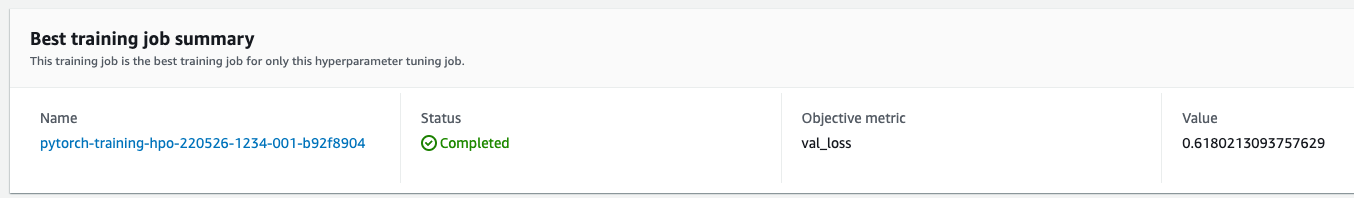

### Using the new model from HPO

We can take the best performing model from the HPO job and then follow the same process of deploying the model for batch inference

### Attach to a training job that has been left to run 

If your kernel becomes disconnected and your training has already started, you can reattach to the training job.<br>
In the cell below, replace **your-unique-bucket-name** with the name of bucket you created in the data-prep notebook<br>
Simply look up the training job name and replace the **your-training-job-name** and then run the cell below. <br>
Once the training job is finished, you can continue the cells after the training cell

In [ ]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
client = boto3.client('sagemaker-runtime')

bucket = "pssummitworkshop2022"

training_job_name = 'pytorch-training-2022-05-26-09-01-42-428'

estimator = sagemaker.estimator.Estimator.attach(training_job_name=training_job_name, sagemaker_session=sess)